# Machine Learning

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from lightgbm.sklearn import LGBMRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import (
    AdaBoostRegressor,
    ExtraTreesRegressor,
    RandomForestRegressor,
)
from sklearn.linear_model import LinearRegression, Ridge, SGDRegressor, LassoCV
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from xgboost.sklearn import XGBRegressor

C:\Users\sit_k\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df_num = pd.read_csv('./data/num_df.csv', index_col=0)

In [3]:
df_num.head()

,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont11,cont14,loss
id,,,,,,,,,,,
1,0.726300,0.245921,0.187583,0.789639,0.310061,0.718367,0.335060,0.30260,0.569745,0.714843,2213.18
2,0.330514,0.737068,0.592681,0.614134,0.885834,0.438917,0.436585,0.60087,0.338312,0.304496,1283.60
5,0.261841,0.358319,0.484196,0.236924,0.397069,0.289648,0.315545,0.27320,0.381398,0.774425,3005.09
10,0.321594,0.555782,0.527991,0.373816,0.422268,0.440945,0.391128,0.31796,0.327915,0.602642,939.85
11,0.273204,0.159990,0.527991,0.473202,0.704268,0.178193,0.247408,0.24564,0.204687,0.432606,2763.85


In [4]:
feature = df_num.drop(['loss'], axis=1)
target = df_num['loss']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(feature, target,
                                                    test_size=.3, random_state=42)

In [6]:
def mae_fun(name, model):
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(
        model, feature, target, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    mae = np.mean(np.absolute(scores))
    print('MAE of using {} is {:.2f}'.format(name, mae))

### Linear Regression Models

Start with simpler model to obtain baseline performance. Linear models are great choices for their ease of explainability to communicate insight to stakeholders

In [7]:
regressors = {'dummy': DummyRegressor(), 'linear': LinearRegression(
), 'ridge': Ridge(), 'SGD': SGDRegressor(), 'lasso' : LassoCV()}

MAE of using dummy is 1809.28
MAE of using linear is 1802.72
MAE of using ridge is 1802.72
MAE of using SGD is 1803.51
MAE of using lasso is 1802.70


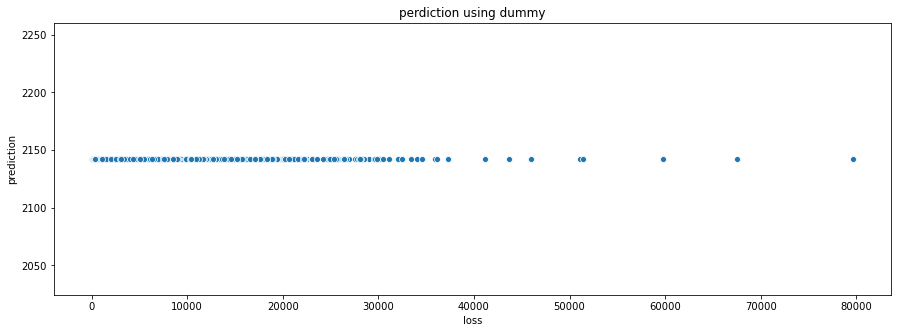

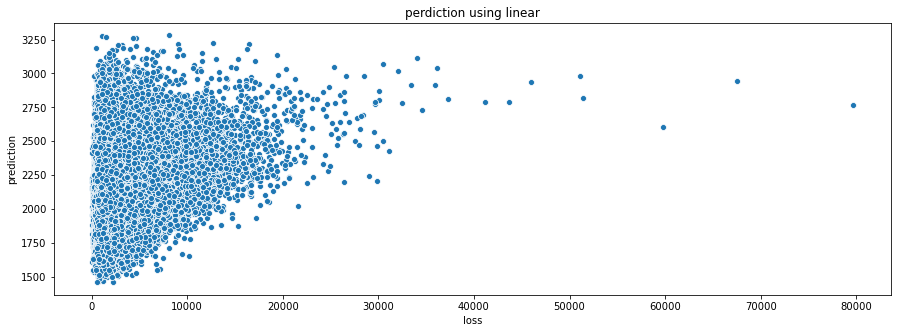

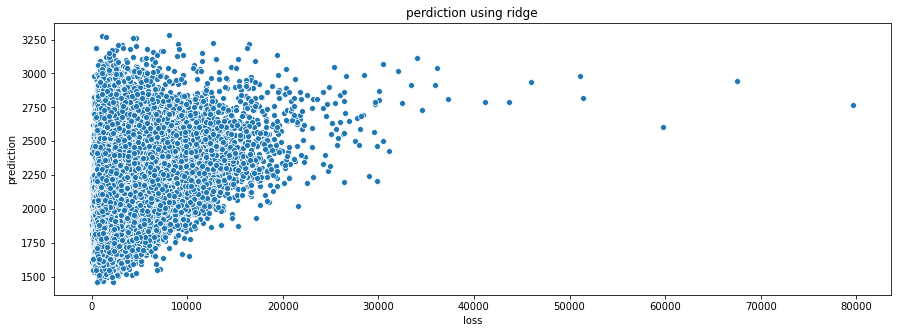

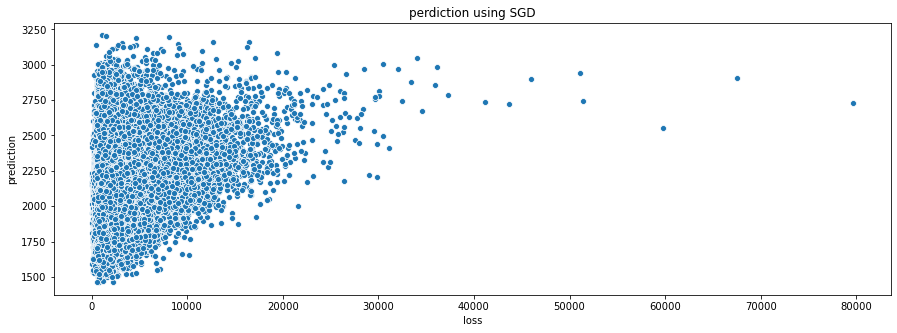

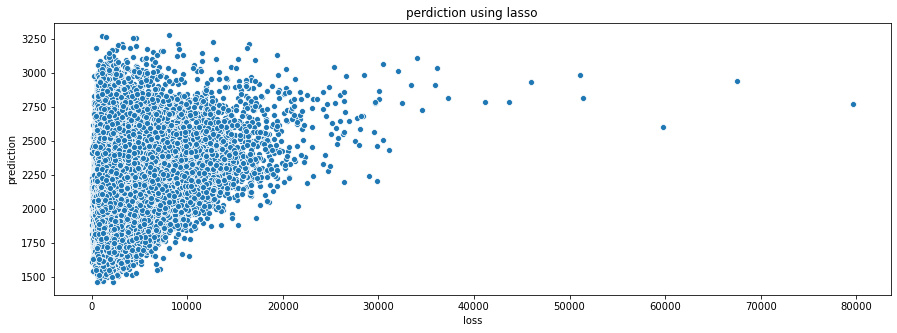

In [8]:
for name, reg in regressors.items():
    mod = TransformedTargetRegressor(
        regressor=reg, transformer=PowerTransformer())
    mod_fit = mod.fit(X_train, y_train)
    pred = mod_fit.predict(X_test)
    plt.figure(figsize=(15, 5))
    sns.scatterplot(x=y_test, y=pred)
    plt.ylabel('prediction')
    plt.title(f'perdiction using {name}')
    mae_fun(name, mod)

Linear models predictions cannot capture outlier very well. Also see that there are significant amount of small value claim that had large value predictions. That would directly results in unnecessary final burden to client with the inaccurate claim estimates.

Moreover, Linear Regression did not do much better than dummy model at the aggregated level, which is a concerning factors.

### Tree Base Ensemble Model



In [9]:
tree_base = {'extra_tree': ExtraTreesRegressor(
), 'random_forest': RandomForestRegressor()}

MAE of using extra_tree is 2122.83
MAE of using random_forest is 1874.31


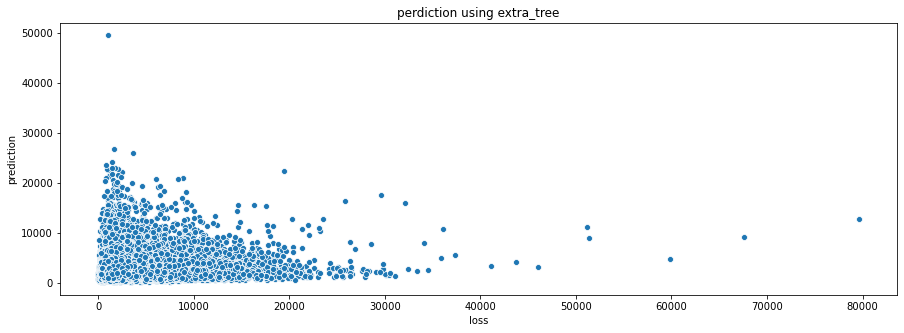

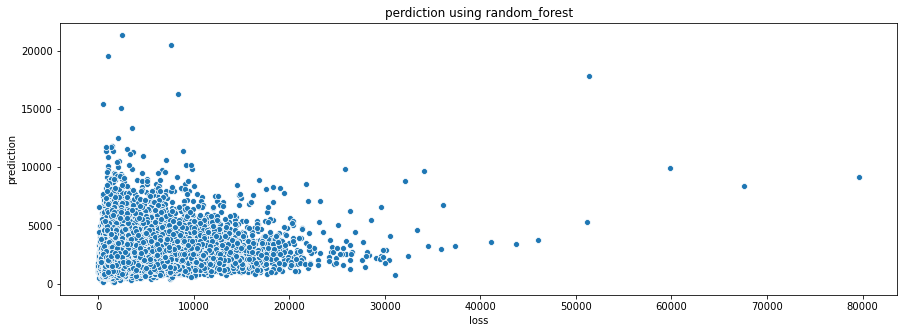

In [10]:
%timeit
for name, reg in tree_base.items():
    mod = TransformedTargetRegressor(
        regressor=reg, transformer=PowerTransformer())
    mod_fit = mod.fit(X_train, y_train)
    pred = mod_fit.predict(X_test)
    plt.figure(figsize=(15, 5))
    sns.scatterplot(x=y_test, y=pred)
    plt.ylabel('prediction')
    plt.title(f'perdiction using {name}')
    mae_fun(name, mod)

Unfortunately, the tree base ensemble methods perform worst than linear models at the aggregated MAE level. The range of prediction are wider, and we observed better accuracy on high claim data points. But the large MAE components would still make the model not desirable for deployment

### Boosting

In [11]:
booster = {'ada': AdaBoostRegressor(), 'lightgbm': LGBMRegressor(),
           'xgboost': XGBRegressor()}

MAE of using ada is 1806.60
MAE of using lightgbm is 1766.31
[21:40:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE of using xgboost is 1769.99


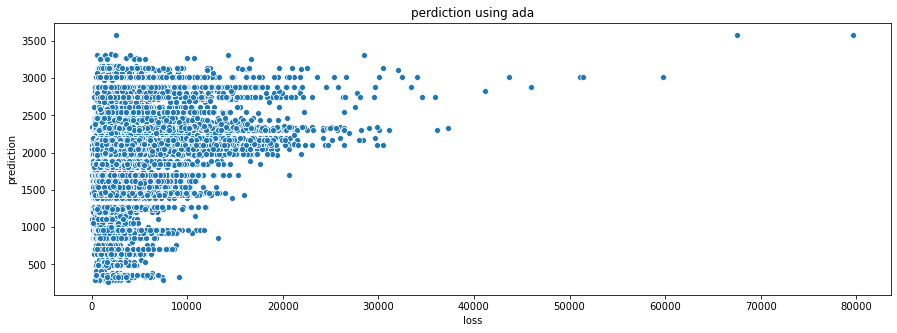

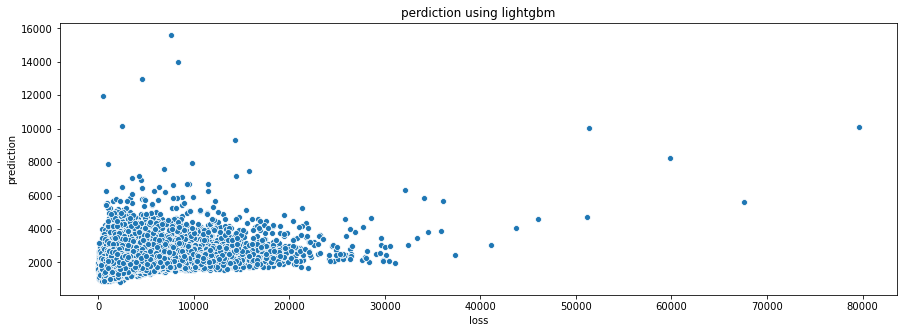

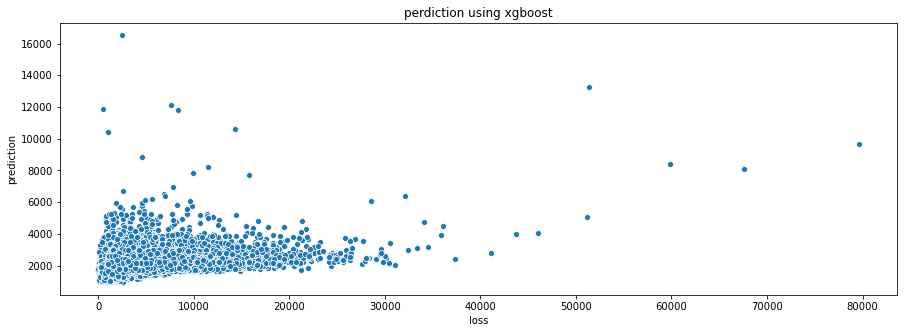

In [12]:
for name, reg in booster.items():
    pipeline = Pipeline(steps=[('normalize', MinMaxScaler()), ('model', reg)])
    mod = TransformedTargetRegressor(
        regressor=pipeline, transformer=PowerTransformer())
    mod_fit = mod.fit(X_train, y_train)
    pred = mod_fit.predict(X_test)
    plt.figure(figsize=(15, 5))
    sns.scatterplot(x=y_test, y=pred)
    plt.ylabel('prediction')
    plt.title(f'perdiction using {name}')
    mae_fun(name, mod)

The boosting models improved on the MAE, and more tuning will be on Lightgbm and Xgboost. So far the model only used continuous variables, next steps will be incorporate categorical features.